## Model Regularisation

---

Data: Donald Trump's tweets, available on my github repo.

We try to predict the success of Donald Trump's tweets as measured by the favorite count (outcome). Our dataset includes tweet-level data with some information about each tweet: timestamp, length. In addition, LDA (latent dirichlet allocation) was used to identify 100 latent 'topics' (components) from tweets' text. Thus, we also have some signals about the contents of each tweet.

**Contents:**

**OLS, Benjamini-Hochberg Method (False Discovery Rate), K-fold Cross Validation**
* OLS regression of favorite_count on length, LDA topics and year dummies. 
* Same OLS regression after splitting into training and test sample to evaluate out of sample R^2
* Benjamini-Hochberg procedure - fix an acceptable FDR and this sets a cut-off for p-values and get a reduced sample with selected features.
* Plot p-value against coefficients ranked by p-value
* K-fold out of sample validation and boxplot of full-sample, reduced-sample fit

**Lasso model**
* Lasso regression after train, test split
* Lasso Regularisation path
* Using K-fold CV and AIC, BIC for selecting optimal lambda for Lasso regression
* K-fold out of sample validation and boxplot of full-sample, reduced-sample, lasso fit

* Running the code on a smaller 10% of the full sample.

**What more to be done:**

* Implement Information criteria only on training or maybe the validation sample.
* Out of sample validation using lambda from information criteria method.

**Some things to keep in mind**
* Factor reference levels matter under penalisation => get rid of the reference level (create separate dummies for each factor level)
* Size of the covariates now matters, as all $\beta_k$ are penalised by the same $\lambda$ => several solutions possible: i) standardise covariates; ii) standardise 𝛽's in the cost function, e.g.by multiplying the coefficients by standard deviation of corresponding covariates. Note: you might still want to avoid standardisation if you have all indicator variables as your covariates. 

---

In [86]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

data = pd.read_csv("tweets_lda.csv")
data.shape

(45539, 110)

In [43]:
data.head()

,id_str,timestamp,retweet_count,favorite_count,year,month,dayofyear,dayofweek,hour,length,...,lda_topic_90,lda_topic_91,lda_topic_92,lda_topic_93,lda_topic_94,lda_topic_95,lda_topic_96,lda_topic_97,lda_topic_98,lda_topic_99
0,1.262024e+18,2020-05-17 09:15:53,9741.0,43484,2020,5,138,6,9,104,...,0.706362,0.002966,0.002966,0.002966,0.002966,0.002966,0.002966,0.002966,0.002966,0.002966
1,1.262020e+18,2020-05-17 09:01:31,11630.0,61214,2020,5,138,6,9,91,...,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926
2,1.262006e+18,2020-05-17 08:03:32,16368.0,0,2020,5,138,6,8,99,...,0.003222,0.003222,0.003222,0.003222,0.003222,0.003222,0.003222,0.003222,0.003222,0.003222
3,1.261999e+18,2020-05-17 07:37:30,7108.0,0,2020,5,138,6,7,140,...,0.002707,0.002707,0.002707,0.002707,0.002707,0.151772,0.002707,0.002707,0.002707,0.002707
4,1.261998e+18,2020-05-17 07:34:18,4685.0,30176,2020,5,138,6,7,75,...,0.002754,0.092606,0.002754,0.002754,0.002754,0.002754,0.002754,0.002754,0.002754,0.002754


In [44]:
# add squared length and take logs of favorite_count and length
data.insert(10, 'length2', data['length']**2)
for x in ['favorite_count', 'length', 'length2']:
    data[x] = np.log(data[x]+1)

In [45]:
data.describe()

,id_str,retweet_count,favorite_count,year,month,dayofyear,dayofweek,hour,length,length2,...,lda_topic_90,lda_topic_91,lda_topic_92,lda_topic_93,lda_topic_94,lda_topic_95,lda_topic_96,lda_topic_97,lda_topic_98,lda_topic_99
count,4.553900e+04,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000,...,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000,45539.000000
mean,7.284901e+17,7902.219175,5.864442,2015.846988,6.462549,181.135115,2.749248,12.946310,4.758605,9.496434,...,0.008139,0.008128,0.012636,0.007836,0.008656,0.008580,0.013430,0.010131,0.008806,0.010735
std,3.512493e+17,12043.921277,4.185435,2.674487,3.506796,106.811303,1.916522,5.679015,0.581156,1.177120,...,0.042186,0.044427,0.060078,0.040547,0.045059,0.043605,0.064314,0.052123,0.045456,0.054446
min,1.698309e+09,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,1.098612,1.609438,...,0.000431,0.000431,0.000714,0.000431,0.000431,0.000714,0.000737,0.000431,0.000714,0.000431
25%,4.174620e+17,37.000000,2.708050,2013.000000,3.000000,87.000000,1.000000,8.000000,4.532599,9.043695,...,0.002291,0.002292,0.002298,0.002293,0.002293,0.002293,0.002298,0.002293,0.002293,0.002297
50%,6.677116e+17,1492.000000,4.882802,2015.000000,7.000000,182.000000,3.000000,13.000000,4.875197,9.735128,...,0.002541,0.002540,0.002552,0.002543,0.002543,0.002544,0.002552,0.002544,0.002544,0.002548
75%,1.103430e+18,13215.000000,10.628485,2019.000000,10.000000,278.500000,4.000000,17.000000,4.941642,9.869000,...,0.002958,0.002955,0.002991,0.002963,0.002965,0.002966,0.002995,0.002967,0.002965,0.002974
max,1.262024e+18,369530.000000,13.687277,2020.000000,12.000000,366.000000,6.000000,23.000000,9.923633,19.847169,...,0.791293,0.793503,0.815971,0.779946,0.805854,0.778821,0.791076,0.818324,0.815091,0.811711


In [46]:
# create dummies for categorical variables

dummies = [pd.get_dummies(data[i], prefix=i, drop_first=True) for i in ['year', 'dayofyear', 'dayofweek', 'hour']]

In [47]:
# Inputs for the regression
y = data['favorite_count']
X = data.iloc[:, 9:].join(dummies)
X.head()

,length,length2,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4,lda_topic_5,lda_topic_6,lda_topic_7,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,4.653960,9.288874,0.002966,0.002966,0.002966,0.002966,0.002966,0.002966,0.002966,0.002966,...,0,0,0,0,0,0,0,0,0,0
1,4.521789,9.021840,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926,...,0,0,0,0,0,0,0,0,0,0
2,4.605170,9.190342,0.003222,0.003222,0.003222,0.003222,0.003222,0.003222,0.356749,0.003222,...,0,0,0,0,0,0,0,0,0,0
3,4.948760,9.883336,0.002707,0.002707,0.002707,0.002707,0.002707,0.002707,0.002707,0.002707,...,0,0,0,0,0,0,0,0,0,0
4,4.330733,8.635154,0.002754,0.002754,0.002754,0.002754,0.002754,0.002754,0.002754,0.002754,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# ordinary least squares
# statsmodel is more suited for traditional econometric analyses, but it is a good starting point 
import statsmodels.api as sm
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
#print(est.summary())
y_pred = est.predict(X)
residuals= y-y_pred


Text(0.5, 0, 'Actual Y')

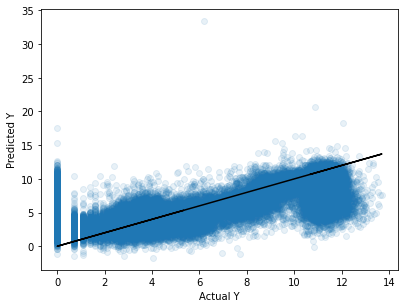

In [87]:
plt.scatter(y,y_pred, alpha=0.1)
plt.plot(y,y, c='k')
plt.ylabel('Predicted Y')
plt.xlabel('Actual Y')

#seems like it is not a great fit.

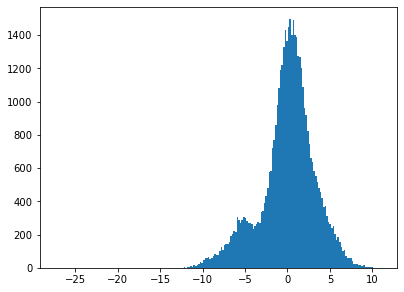

In [99]:
#plotting residuals
plt.hist(residuals, bins='auto')
plt.show()

In [49]:
# alternative using sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y = data['favorite_count']
X = data.iloc[:, 9:].join(dummies)

regr = LinearRegression() 
regr.fit(X, y)

# Make in-sample predictions 
y_pred = regr.predict(X)
# The mean squared error
print('Mean squared error in-sample: %.3f'
      % mean_squared_error(y, y_pred))
# In-sample R-sq.
print('In-sample Rsq: %.3f'
      % r2_score(y, y_pred))


Mean squared error in-sample: 10.303
In-sample Rsq: 0.412


In [50]:
# dividing into training and test data and evaluating out of sample rsq.
# if we increase test_size then there wouldnt be enough sample to train and out of sample r2 will be lower

In-sample Rsq:  0.1746
Out-of-sample Rsq:  0.1376


Text(0.5, 0, 'Actual Y')

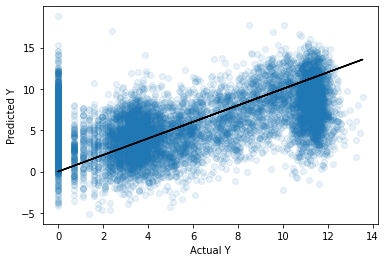

In [40]:
from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.pipeline import Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.model_selection import train_test_split

y = data['favorite_count']
X = data.iloc[:, 9:].join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns) #Fotran array to save memory and improve computation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()), 
                 ('regr', LinearRegression(fit_intercept=False, copy_X=False))])
# It avoids leaking the test set into the train set

pipe.fit(X_train, y_train)

y_pred = pipe.fit(X_train, y_train).predict(X_test)

print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

plt.scatter(y_test,y_pred, alpha=0.1)
plt.plot(y_test,y_test, c='k')
plt.ylabel('Predicted Y')
plt.xlabel('Actual Y')

In [44]:
# apply Benjamini - Hochberg as a first attempt to regularise the model 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFdr.html

from sklearn.feature_selection import SelectFdr, f_regression
y = data['favorite_count']
X = data.iloc[:, 9:].join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
X.head()

,length,length2,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4,lda_topic_5,lda_topic_6,lda_topic_7,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,4.653960,9.288874,0.002966,0.002966,0.002966,0.002966,0.002966,0.002966,0.002966,0.002966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.521789,9.021840,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926,0.002926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.605170,9.190342,0.003222,0.003222,0.003222,0.003222,0.003222,0.003222,0.356749,0.003222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.948760,9.883336,0.002707,0.002707,0.002707,0.002707,0.002707,0.002707,0.002707,0.002707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.330733,8.635154,0.002754,0.002754,0.002754,0.002754,0.002754,0.002754,0.002754,0.002754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
X = StandardScaler().fit_transform(X)
X

array([[-0.18006552, -0.1763307 , -0.1066208 , ..., -0.22707552,
        -0.21387772, -0.17344847],
       [-0.4074972 , -0.40318718, -0.10754473, ..., -0.22707552,
        -0.21387772, -0.17344847],
       [-0.26402012, -0.26003802, -0.10065519, ..., -0.22707552,
        -0.21387772, -0.17344847],
       ...,
       [ 0.00614064,  0.00919223, -0.12336023, ..., -0.22707552,
        -0.21387772, -0.17344847],
       [ 0.21370861,  0.21579886, -0.12565686, ..., -0.22707552,
        -0.21387772, -0.17344847],
       [ 0.02078522,  0.02377563, -0.12248485, ..., -0.22707552,
        -0.21387772, -0.17344847]])

In [50]:
fdr = SelectFdr(f_regression, alpha=0.05) # here alpha is our acceptable rate of finding false positives 
X_new =fdr.fit_transform(X, y) 
X_new

array([[-0.18006552, -0.1763307 , -0.13775902, ..., -0.20647308,
        -0.21387772, -0.17344847],
       [-0.4074972 , -0.40318718, -0.13856361, ..., -0.20647308,
        -0.21387772, -0.17344847],
       [-0.26402012, -0.26003802, -0.13256399, ..., -0.20647308,
        -0.21387772, -0.17344847],
       ...,
       [ 0.00614064,  0.00919223, -0.15233622, ..., -0.20647308,
        -0.21387772, -0.17344847],
       [ 0.21370861,  0.21579886, -0.15433619, ..., -0.20647308,
        -0.21387772, -0.17344847],
       [ 0.02078522,  0.02377563, -0.15157391, ..., -0.20647308,
        -0.21387772, -0.17344847]])

In [51]:
print(X.shape, X_new.shape)

(45539, 507) (45539, 237)


In [52]:
# Cutoff pvalue for selected features 
sorted = pd.Series(fdr.pvalues_).sort_values(axis=0, ascending=True).reset_index(drop = True)
print("Cutoff p-value: % .4f" % sorted.loc[X_new.shape[1]])

# Note that transpose is not necessary here. 

Cutoff p-value:  0.0240


In [53]:
# I believe we try to find that p_value corresponding to the 237th feature as the cutoff
pd.Series(fdr.pvalues_).sort_values().reset_index(drop=True)[237]      

0.024029820899931886

<AxesSubplot:title={'center':'Ordered p-values'}, xlabel='Coefficients ranked by p-value', ylabel='P-value'>

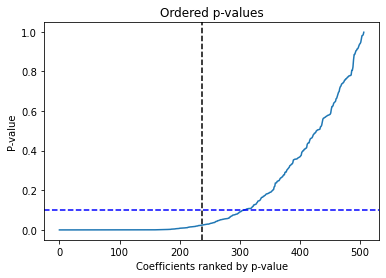

In [54]:
# Plot ordered pvalues
ax = sorted.plot.line(title = "Ordered p-values")
ax.set(xlabel="Coefficients ranked by p-value", ylabel="P-value")
ax.axvline(X_new.shape[1], color='k', linestyle='--')
ax.axhline(0.1, color='b', linestyle='--', label = 'p-value = 0.1')
ax

In [55]:
# Again we can get a rough idea of the prediction power using sample-splitting 

y = data['favorite_count']
X = data.iloc[:, 9:].join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)

# ! it is more correct to perform FDR only on the train data, therefore it is inside the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.1)),
                 ('regr', LinearRegression(fit_intercept = True, copy_X=False))])

pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.4036
Out-of-sample Rsq:  0.3814


In [58]:
# Use K-fold out-of-sample validation to compare the predictive power of the full and of the reduced model
from sklearn.model_selection import KFold, cross_val_score

y = data['favorite_count']
X = data.iloc[:, 9:].join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('regr', LinearRegression(fit_intercept = True, copy_X=False))])
scores_full = cross_val_score(pipe, X, y, cv=kf)
print(scores_full)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_full.mean(), scores_full.std() * 2))

[0.38501018 0.40232571 0.39930238 0.38969011 0.40940996]
Accuracy: 0.39715 (+/- 0.01754)


In [59]:
# similarly on reduced sample
y = data['favorite_count']
X = data.iloc[:, 9:].join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.05)),
                 ('regr', LinearRegression(fit_intercept = True, copy_X=False))])
scores_reduced = cross_val_score(pipe, X, y, cv=kf)
print(scores_reduced)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_reduced.mean(), scores_reduced.std() * 2))

[0.37588449 0.39574251 0.38871676 0.38035824 0.40147484]
Accuracy: 0.38844 (+/- 0.01889)


Text(0.5, 1.0, 'Out-of-sample validation')

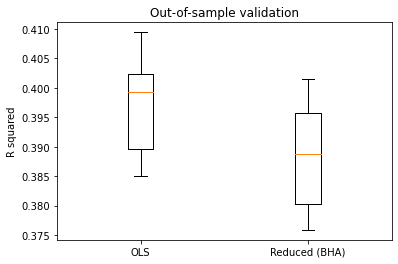

In [60]:
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_reduced])
plt.xticks([1, 2], ['OLS', 'Reduced (BHA)'])
plt.ylabel('R squared')
plt.title('Out-of-sample validation')

In [61]:
# Reasons for OLS giving better performance

# Sample size > no.of regressors and the regressors are already derived from an LDA model (LDA extracted informative signals)

In [116]:
# Lasso regression

from sklearn.linear_model import Lasso
y = data['favorite_count']

# it is recommended to drop the reference category
dummies = [pd.get_dummies(data[i], prefix=i, drop_first = False) for i in ['year', 'dayofyear', 'dayofweek', 'hour']]

X = data.iloc[:, 9:].join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.05, fit_intercept=True, copy_X=False, max_iter=10000))])
# note alpha is same as lambda in the model, here an arbitrary value - it is not the optimal! 

pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))
#pipe.named_steps.lasso.coef_

In-sample Rsq:  0.3772
Out-of-sample Rsq:  0.3643


In [118]:
# Lasso Regularisation path

from sklearn.linear_model import lasso_path, enet_path

y = data['favorite_count']
X = data.iloc[:, 9:].join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
X = StandardScaler().fit_transform(X) 

# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000)
print("Ready")

Computing regularization path using the lasso...
Ready


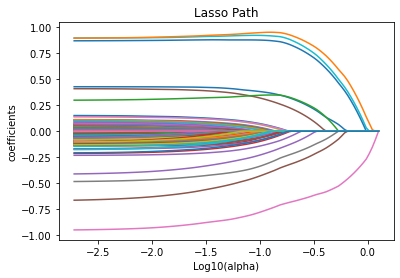

In [99]:
# Display results
plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')
plt.show()
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

In [106]:

#It shows the path of estimated coefficients for different values of 𝜆. When 𝜆 approaches zero, we are close to the OLS 
#with all the variables. The path also shows us the 𝜆 when all the coefficients are zero (null model). For this graph such 
#𝜆 is around 1. It is helpful for the next step, when we define the search grid to find the optimal 𝜆. 


In [ ]:
# Using cross-validation and information criteria to select best lambda.

In [111]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 

from sklearn.linear_model import LassoCV
import time

y = data['favorite_count']
X = data.iloc[:, 9:].join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=10, max_iter=10000, alphas=np.logspace(-2.2, -0.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X, y)
t_cv = time.time() - t1
print("Ready")

Computing Lasso CV...
Ready


In [112]:
l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Optimal alpha =  0.0094 
Training time =  32.9587s 


(-2.285, -0.415, 0.6470582688647228, 36.29401096739047)

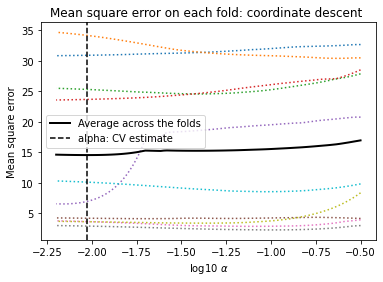

In [113]:
# Display results
log_alphas_lasso = np.log10(l.alphas_)

plt.figure()
plt.plot(log_alphas_lasso , l.mse_path_, ':')
plt.plot(log_alphas_lasso , l.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(l.alpha_) , linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'log10 $\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')

In [109]:
# We can compare this result with alpha selected with BIC/AIC criterion
from sklearn.linear_model import  LassoLarsIC
from sklearn.pipeline import make_pipeline

model_bic = make_pipeline(StandardScaler(), LassoLarsIC(criterion='bic', normalize=False)).fit(X, y)
t1 = time.time()
t_bic = time.time() - t1
alpha_bic_ = model_bic[-1].alpha_
  
model_aic = make_pipeline(StandardScaler(), LassoLarsIC(criterion='aic', normalize=False)).fit(X, y)
alpha_aic_ = model_aic[-1].alpha_
print("Ready")
print("Optimal alpha aic = % .6f " % alpha_aic_)
print("Optimal alpha bic = % .6f " % alpha_bic_)
print("Training time = % .4fs " % t_bic)

Ready
Optimal alpha aic =  0.044375 
Optimal alpha bic =  0.160827 
Training time =  0.0000s 


In [111]:
# we store the results for aic and bic
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py
results = pd.DataFrame(
    {
        "alphas": model_bic[-1].alphas_,
        "AIC criterion": model_aic[-1].criterion_,
        "BIC criterion": model_bic[-1].criterion_
    }
).set_index("alphas")
results

,AIC criterion,BIC criterion
alphas,,
1.251338,26652.852589,26652.852589
1.049968,26455.435173,26461.858934
0.976319,26343.117667,26355.965189
0.956216,26299.555467,26318.826750
0.738590,25686.194875,25711.889920
...,...,...
0.001395,24214.037452,27400.223031
0.001311,24215.983768,27408.593108
0.001263,24212.817483,27411.850584


In [112]:
# we highlight the min value for both criterion
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

#results.shape
results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
1.251337922093597,26652.852589,26652.852589
1.049967606975448,26455.435173,26461.858934
0.9763185760570025,26343.117667,26355.965189
0.9562160277288676,26299.555467,26318.826750
0.7385900418106989,25686.194875,25711.889920
0.6181661151280822,25384.706795,25416.825601
0.6144815190322427,25377.013144,25415.555711
0.4787121461131211,24975.610838,25020.577167
0.37014395966700314,24713.817242,24765.207332


Text(0.5, 1.0, 'Information-criterion for model selection ')

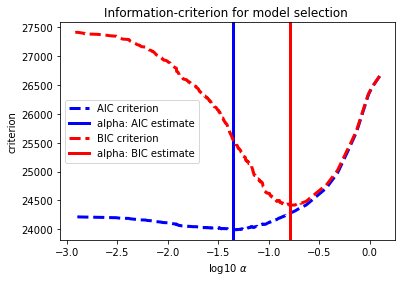

In [107]:
def plot_ic_criterion(model, name, color):
    criterion_ = model[-1].criterion_
    plt.plot(np.log10(model[-1].alphas_), criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(np.log10(model[-1].alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'log10 $\alpha$')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection ')

In [121]:
# but the problem is we used full sample, need to try it again with training sample only.

In [125]:
# Compare performance of lasso model with the baseline model
y = data['favorite_count']
X = data.iloc[:, 9:].join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, copy_X=False, max_iter=10000))])
scores_lasso = cross_val_score(pipe, X, y, cv=kf)
print(scores_lasso)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

# if you decide to check for AIC, will take time, as lambda is very small, the result will be very close to a simple OLS

[0.37623599 0.39219704 0.38695719 0.3847887  0.40060594]
Accuracy: 0.38816 (+/- 0.01615)


Text(0.5, 1.0, 'Out-of-sample validation')

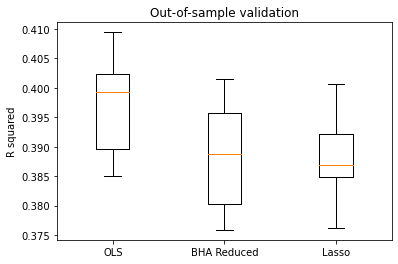

In [126]:
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_reduced, scores_lasso])
plt.xticks([1, 2, 3], ['OLS', 'BHA Reduced', 'Lasso'])
plt.ylabel('R squared')
plt.title('Out-of-sample validation')

In [127]:
# checking performance on a small sample

In [128]:
# randomly select only 10% from our sample
data_sm = data.sample(frac=0.1, replace=False, weights=None, random_state=1, axis=0)
data_sm.describe()

,id_str,retweet_count,favorite_count,year,month,dayofyear,dayofweek,hour,length,length2,...,lda_topic_90,lda_topic_91,lda_topic_92,lda_topic_93,lda_topic_94,lda_topic_95,lda_topic_96,lda_topic_97,lda_topic_98,lda_topic_99
count,4.554000e+03,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,...,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000
mean,7.286968e+17,7889.556873,5.840328,2015.851998,6.430391,180.160957,2.689504,12.999561,4.753860,9.486688,...,0.007818,0.009239,0.012720,0.006961,0.007570,0.008512,0.014576,0.010116,0.008802,0.010837
std,3.536381e+17,12062.940382,4.186149,2.693520,3.519655,107.127782,1.929060,5.599881,0.589705,1.194832,...,0.042218,0.050596,0.060653,0.035102,0.038270,0.042506,0.065187,0.054178,0.045500,0.055658
min,1.864367e+09,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,1.791759,3.258097,...,0.000714,0.000714,0.000714,0.000714,0.000828,0.000714,0.000828,0.000714,0.000714,0.000714
25%,4.100225e+17,39.000000,2.656306,2013.000000,3.000000,84.000000,1.000000,8.000000,4.532599,9.043695,...,0.002296,0.002296,0.002302,0.002296,0.002296,0.002296,0.002302,0.002294,0.002296,0.002301
50%,6.633298e+17,1484.000000,4.927254,2015.000000,7.000000,183.000000,3.000000,13.000000,4.875197,9.735128,...,0.002545,0.002545,0.002554,0.002546,0.002545,0.002548,0.002557,0.002543,0.002546,0.002550
75%,1.108288e+18,13256.250000,10.591905,2019.000000,10.000000,279.000000,4.000000,17.000000,4.941642,9.869000,...,0.002952,0.002959,0.002989,0.002957,0.002957,0.002970,0.003012,0.002956,0.002962,0.002969
max,1.261787e+18,220796.000000,13.546760,2020.000000,12.000000,365.000000,6.000000,23.000000,8.590815,17.181259,...,0.780118,0.793503,0.781814,0.664258,0.688657,0.739698,0.754312,0.760431,0.774097,0.759072


In [129]:
dummies = [pd.get_dummies(data_sm[i], prefix=i, drop_first = False) for i in ['year', 'dayofyear', 'dayofweek', 'hour']]

y = data_sm['favorite_count']
X = data_sm.iloc[:, 9:].join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)

In [138]:
# K-fold cross-validation
# Linear model
kf = KFold(n_splits=10, shuffle=True, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('regr', LinearRegression(fit_intercept = True, copy_X=False))])
scores_full = cross_val_score(pipe, X, y, cv=kf)
print(scores_full)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_full.mean(), scores_full.std() * 2))

[0.26572885 0.30476552 0.32019744 0.26074018 0.32501415 0.35355867
 0.34363341 0.2184058  0.28357374 0.30286023]
Accuracy: 0.29785 (+/- 0.07857)


In [131]:
# FDR selection
pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.05)),
                 ('regr', LinearRegression(fit_intercept = True, copy_X=False, n_jobs=-1))])
scores_reduced = cross_val_score(pipe, X, y, cv=kf)
print(scores_reduced)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_reduced.mean(), scores_reduced.std() * 2))

[0.32883862 0.34887843 0.35428805 0.32533431 0.33910206]
Accuracy: 0.33929 (+/- 0.02229)


In [132]:
# optimal lasso penalty
# note how it changes compared to the previous case with a bigger sample 
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-2.5, -0.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X, y)
t_cv = time.time() - t1
print("Ready")
l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0566 
Training time =  2.6361s 


In [133]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, copy_X=False, max_iter=10000))])
scores_lasso = cross_val_score(pipe, X, y, cv=kf)
print(scores_lasso)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

[0.32527731 0.34246206 0.35390632 0.31654732 0.34945735]
Accuracy: 0.33753 (+/- 0.02864)


Text(0.5, 1.0, 'Out-of-sample validation, smaller sample')

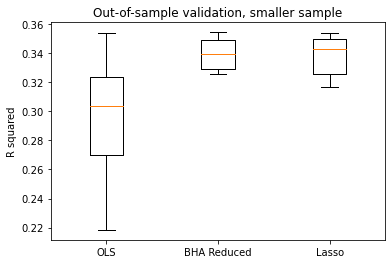

In [139]:
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_reduced, scores_lasso])
plt.xticks([1, 2, 3], ['OLS', 'BHA Reduced', 'Lasso'])
plt.ylabel('R squared')
plt.title('Out-of-sample validation, smaller sample')

In [ ]:
# regularised models seem better after we reduced the sample size as OLS would run into overfitting